In [34]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment, effects
import noisereduce as nr
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [35]:
df = pd.read_csv('data/songs_wav.csv')

In [36]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    
    Args:
        filename (str): The original filename or folder name.
        
    Returns:
        str: The sanitized filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    """
    Normalizes a YouTube title by converting it to lowercase, replacing spaces with underscores,
    and removing non-alphanumeric characters except underscores.
    
    Args:
        title (str): The original title of the YouTube video.
        
    Returns:
        str: The normalized title.
    """
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

def remove_silence(audio, threshold=20):
    """
    Removes silent sections from an audio signal based on a decibel threshold.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        threshold (int): The decibel threshold to trim silence. Defaults to 20.
        
    Returns:
        ndarray: The trimmed audio signal.
    """
    return librosa.effects.trim(audio, top_db=threshold)[0]

def normalize_audio(audio):
    """
    Normalizes the audio signal to a standard volume level.
    
    Args:
        audio (AudioSegment): The audio segment to normalize.
        
    Returns:
        AudioSegment: The normalized audio segment.
    """
    return effects.normalize(audio)

def noise_reduction(audio, noise_profile):
    """
    Reduces noise from an audio signal using a noise profile.
    
    Args:
        audio (ndarray): The audio signal as a numpy array.
        noise_profile (ndarray): The noise profile as a numpy array.
        
    Returns:
        ndarray: The noise-reduced audio signal.
    """
    return nr.reduce_noise(audio_clip=audio, noise_clip=noise_profile)

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    """
    Splits songs into 30-second segments and saves them as individual files.
    
    Args:
        df (DataFrame): A pandas DataFrame containing song metadata with 'wav_path' and 'nama_lagu' columns.
        output_base_folder (str): The base folder to save the segments. Defaults to 'datasets/30s_segments'.
        
    Returns:
        None
    """
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        nama_lagu = row['nama_lagu']
        
        os.makedirs(f"{output_base_folder}/{normalized_yt_title(nama_lagu)}", exist_ok=True)
        
        audio = AudioSegment.from_wav(wav_path)
        audio = audio.set_channels(1)
        
        audio = normalize_audio(audio)
        
        total_duration = len(audio) / 1000
        segment_duration = 30
        num_segments = int(total_duration // segment_duration)
        
        for i in range(num_segments):
            start_time = i * segment_duration * 1000 
            end_time = (i + 1) * segment_duration * 1000
            segment = audio[start_time:end_time]
            
            segment_file = f"{output_base_folder}/{normalized_yt_title(nama_lagu)}/segment_{index}_{i}.wav"
            segment.export(segment_file, format="wav")
            
            split_result.append({
                'title': nama_lagu,
                '30s_path': segment_file
            })
        print(f"Saved {num_segments} segments for {nama_lagu} at: {output_base_folder}/{normalized_yt_title(nama_lagu)}")

In [37]:
split_songs_to_segments(df)

Saved 8 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 12 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 4 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 10 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 9 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 6 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 5 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 3 segments for Kicir-kicir at: datasets/30s_segments/kicirkicir
Saved 7 segments f

In [38]:
# save split result to csv
split_result_df = pd.DataFrame(split_result)
split_result_df.to_csv('data/30s_segments.csv', index=False)

In [39]:
df_res = pd.read_csv('data/30s_segments.csv')
df_res.head()

,title,30s_path
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_2.wav
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_3.wav
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_4.wav


### Data Augmentation

In [40]:
def noise(data):
    """
    Adds random noise to an audio signal to augment data.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with added noise.
    """
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    """
    Stretches or compresses the audio by a given rate.

    Args:
        data (ndarray): The audio signal as a numpy array.
        rate (float): The rate to stretch the audio. A value > 1 speeds it up, < 1 slows it down.

    Returns:
        ndarray: The time-stretched audio signal.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift(data, sample_rate):
    """
    Shifts the pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.
        sample_rate (int): The sampling rate of the audio signal.

    Returns:
        ndarray: The pitch-shifted audio signal.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    Adjusts both the speed and pitch of an audio signal.

    Args:
        data (ndarray): The audio signal as a numpy array.

    Returns:
        ndarray: The audio signal with modified speed and pitch.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def pad_or_truncate(data, length):
    """
    Pads or truncates an audio signal to the specified length.

    Args:
        data (ndarray): The audio signal as a numpy array.
        length (int): The desired length of the audio signal.

    Returns:
        ndarray: The audio signal padded or truncated to the specified length.
    """
    if len(data) > length:
        return data[:length]
    elif len(data) < length:
        return np.pad(data, (0, length - len(data)), 'constant')
    
    return data

### Feature Extraction

In [41]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) features from the dataset.

    Args:
        data (pandas.DataFrame): A DataFrame containing paths to audio files and their titles.

    Returns:
        list: A list of dictionaries with titles, paths, and extracted features.
    """
    try:
        for index, row in data.iterrows():
            audio, sample_rate = librosa.load(row['30s_path'])
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x: speedNpitch(x)
            ]

            extract_res.append({
                'title': row['title'],
                '30s_path': row['30s_path'],
                'features': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                extract_res.append({
                    'title': row['title'],
                    '30s_path': row['30s_path'],
                    'features': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {data['30s_path']}")
        return None 

def chroma_features(file_path):
    """
    Extract chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed chroma features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        chroma_processed = np.mean(chroma.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return chroma_processed

def mel_features(file_path):
    """
    Extract Mel-spectrogram features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed Mel-spectrogram features.
    """
    try:
        audio, sample_rate = librosa.load(file_path) 
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
        mel_processed = np.mean(mel.T,axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mel_processed

def combined_features(file_path):
    """
    Combine MFCC and chroma features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Concatenated features of MFCC and chroma.
    """
    mfcc = mfcc_features(file_path)
    chroma = chroma_features(file_path)
    # mel = mel_features(file_path)
    
    return np.concatenate((mfcc, chroma))

In [42]:
features = mfcc_features(df_res)
df_features = pd.DataFrame(features)

In [43]:
df_features.to_csv('data/30s_segments_features.csv', index=False)
df_features.head()

,title,30s_path,features
0,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-239.42424, 98.03014, 7.972566, 15.686206, 5...."
1,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-88.61130580150618, 33.69310555147082, 15.662..."
2,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_0.wav,"[-312.61584, 65.76842, 0.18668926, 9.734197, 5..."
3,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-158.31898, 93.41291, 22.756842, 37.474716, 1..."
4,Kicir-kicir,datasets/30s_segments/kicirkicir/segment_0_1.wav,"[-155.2345679165902, 90.69286100612311, 23.906..."


In [44]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_score(clf, X_train, y_train, X_test, y_test, train=True):    
    if train:
        pred = clf.predict(X_train)
        clf_report = classification_report(y_train, pred, zero_division=1)
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = classification_report(y_test, pred, zero_division=1)
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print(f"F1 Score: {f1_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred, average='weighted', zero_division=1) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


In [45]:
from sklearn.model_selection import train_test_split

# Prepare the data
X = []
y = []

for index, row in df_features.iterrows():
    label = row['title']
    features = row['features']
    
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [46]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (9738, 40), y shape: (9738,)


### RANDOM FOREST

In [47]:
from sklearn.ensemble import RandomForestClassifier
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [48]:
# Evaluate the model
print_score(model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00      1401
             Apuse       1.00      1.00      1.00      1434
     Bengawan Solo       1.00      1.00      1.00      2072
       Kicir-kicir       1.00      1.00      1.00      1593
 Yamko Rambe Yamko       1.00      1.00      1.00      1290

          accuracy                           1.00      7790
         macro avg       1.00      1.00      1.00      7790
      weighted avg       1.00      1.00      1.00      7790

_______________________________________________
Confusion Matrix: 
 [[1401    0    0    0    0]
 [   0 1434    0    0    0]
 [   0    0 2072    0    0]
 [   0    0    0 1593    0]
 [   0    0    0    0 1290]]



In [49]:
print_score(model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 94.30%
F1 Score: 94.30%
Precision Score: 94.49%
Recall Score: 94.30%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.98      0.93      0.95       354
             Apuse       0.97      0.95      0.96       354
     Bengawan Solo       0.89      0.99      0.94       496
       Kicir-kicir       0.96      0.96      0.96       414
 Yamko Rambe Yamko       0.94      0.87      0.91       330

          accuracy                           0.94      1948
         macro avg       0.95      0.94      0.94      1948
      weighted avg       0.94      0.94      0.94      1948

_______________________________________________
Confusion Matrix: 
 [[329   2   7   7   9]
 [  1 335  12   3   3]
 [  0   1 489   3   3]
 [  1   3  12 396   2]
 [  6   4  29   3 288]]



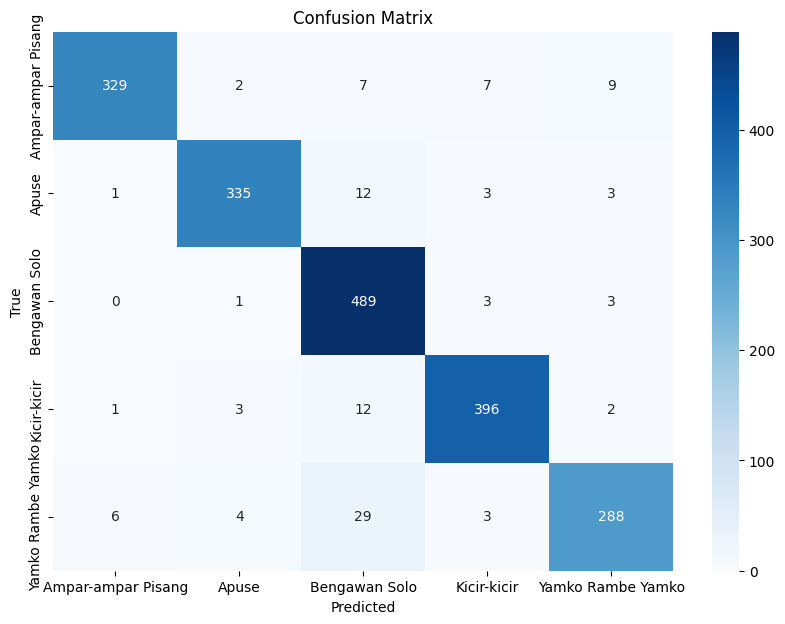

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVM - Supervised ML

In [ ]:
from sklearn.svm import SVC

# Train an SVM model
svm_model = SVC(kernel='linear', random_state=42, C=1, probability=True)
svm_model.fit(X_train, y_train)


In [52]:
# Evaluate the SVM model
print_score(svm_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 65.06%
F1 Score: 64.89%
Precision Score: 65.18%
Recall Score: 65.06%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.70      0.65      0.67      1401
             Apuse       0.66      0.61      0.64      1434
     Bengawan Solo       0.63      0.76      0.69      2072
       Kicir-kicir       0.64      0.62      0.63      1593
 Yamko Rambe Yamko       0.64      0.56      0.60      1290

          accuracy                           0.65      7790
         macro avg       0.65      0.64      0.64      7790
      weighted avg       0.65      0.65      0.65      7790

_______________________________________________
Confusion Matrix: 
 [[ 913   65  203  125   95]
 [ 122  878  222  134   78]
 [  78  124 1574  159  137]
 [  99  166  245  980  103]
 [  99   93  240  135  723]]



In [53]:

print_score(svm_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 62.73%
F1 Score: 62.56%
Precision Score: 62.79%
Recall Score: 62.73%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.64      0.61      0.63       354
             Apuse       0.64      0.61      0.63       354
     Bengawan Solo       0.62      0.74      0.67       496
       Kicir-kicir       0.64      0.58      0.61       414
 Yamko Rambe Yamko       0.60      0.55      0.57       330

          accuracy                           0.63      1948
         macro avg       0.63      0.62      0.62      1948
      weighted avg       0.63      0.63      0.63      1948

_______________________________________________
Confusion Matrix: 
 [[217  19  48  39  31]
 [ 37 217  55  28  17]
 [ 16  39 366  35  40]
 [ 41  45  55 242  31]
 [ 28  20  69  33 180]]



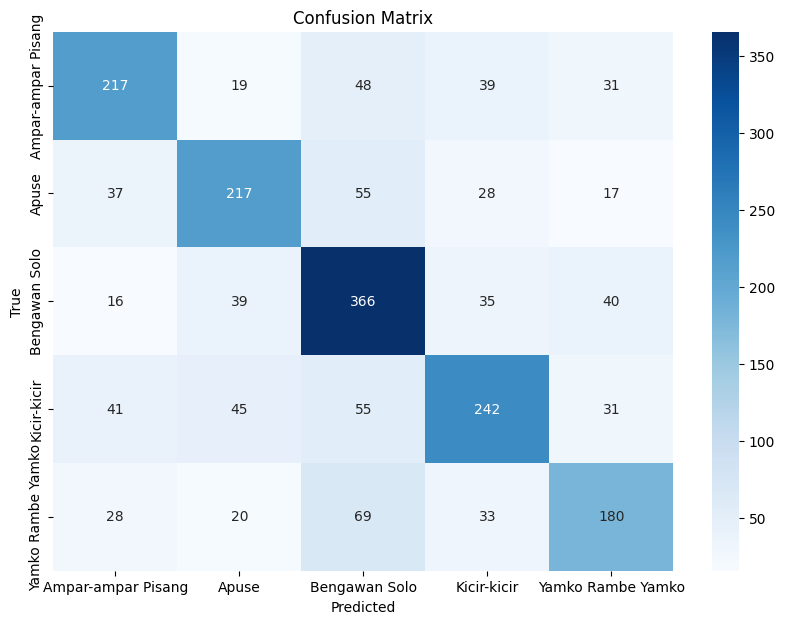

In [54]:
# confusion matrix
y_pred = svm_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Decision Tree's

In [55]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [56]:
# Evaluate the Decision Tree model on the training data
print_score(dt_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 100.00%
F1 Score: 100.00%
Precision Score: 100.00%
Recall Score: 100.00%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       1.00      1.00      1.00      1401
             Apuse       1.00      1.00      1.00      1434
     Bengawan Solo       1.00      1.00      1.00      2072
       Kicir-kicir       1.00      1.00      1.00      1593
 Yamko Rambe Yamko       1.00      1.00      1.00      1290

          accuracy                           1.00      7790
         macro avg       1.00      1.00      1.00      7790
      weighted avg       1.00      1.00      1.00      7790

_______________________________________________
Confusion Matrix: 
 [[1401    0    0    0    0]
 [   0 1434    0    0    0]
 [   0    0 2072    0    0]
 [   0    0    0 1593    0]
 [   0    0    0    0 1290]]



In [57]:
# Evaluate the Decision Tree model on the test data
print_score(dt_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 79.16%
F1 Score: 79.20%
Precision Score: 79.29%
Recall Score: 79.16%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.82      0.82      0.82       354
             Apuse       0.86      0.80      0.83       354
     Bengawan Solo       0.78      0.81      0.79       496
       Kicir-kicir       0.80      0.80      0.80       414
 Yamko Rambe Yamko       0.71      0.72      0.72       330

          accuracy                           0.79      1948
         macro avg       0.79      0.79      0.79      1948
      weighted avg       0.79      0.79      0.79      1948

_______________________________________________
Confusion Matrix: 
 [[290   7  20  17  20]
 [ 20 282  19  15  18]
 [ 10  17 400  31  38]
 [ 12  10  38 331  23]
 [ 21  13  36  21 239]]



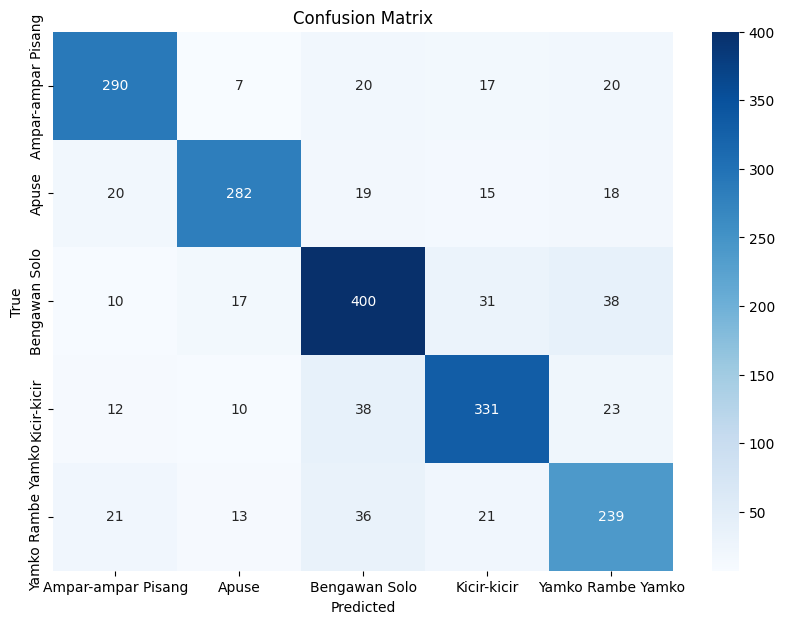

In [58]:
# confusion matrix
y_pred = dt_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [59]:
# knn
from sklearn.neighbors import KNeighborsClassifier

# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 92.34%
F1 Score: 92.34%
Precision Score: 92.43%
Recall Score: 92.34%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.87      0.94      0.90      1401
             Apuse       0.94      0.92      0.93      1434
     Bengawan Solo       0.94      0.94      0.94      2072
       Kicir-kicir       0.95      0.93      0.94      1593
 Yamko Rambe Yamko       0.92      0.87      0.89      1290

          accuracy                           0.92      7790
         macro avg       0.92      0.92      0.92      7790
      weighted avg       0.92      0.92      0.92      7790

_______________________________________________
Confusion Matrix: 
 [[1323   14   22   14   28]
 [  68 1314   19   12   21]
 [  40   19 1957   20   36]
 [  35   33   32 1477   16]
 [  58   22   54   34 1122]]



In [61]:
print_score(knn_model, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 86.60%
F1 Score: 86.60%
Precision Score: 86.69%
Recall Score: 86.60%
_______________________________________________
CLASSIFICATION REPORT:
                    precision    recall  f1-score   support

Ampar-ampar Pisang       0.82      0.89      0.85       354
             Apuse       0.89      0.87      0.88       354
     Bengawan Solo       0.88      0.88      0.88       496
       Kicir-kicir       0.89      0.87      0.88       414
 Yamko Rambe Yamko       0.85      0.80      0.82       330

          accuracy                           0.87      1948
         macro avg       0.86      0.86      0.86      1948
      weighted avg       0.87      0.87      0.87      1948

_______________________________________________
Confusion Matrix: 
 [[316   9   7   5  17]
 [ 22 309  10   6   7]
 [ 18   7 437  15  19]
 [ 15  15  18 361   5]
 [ 16   8  25  17 264]]



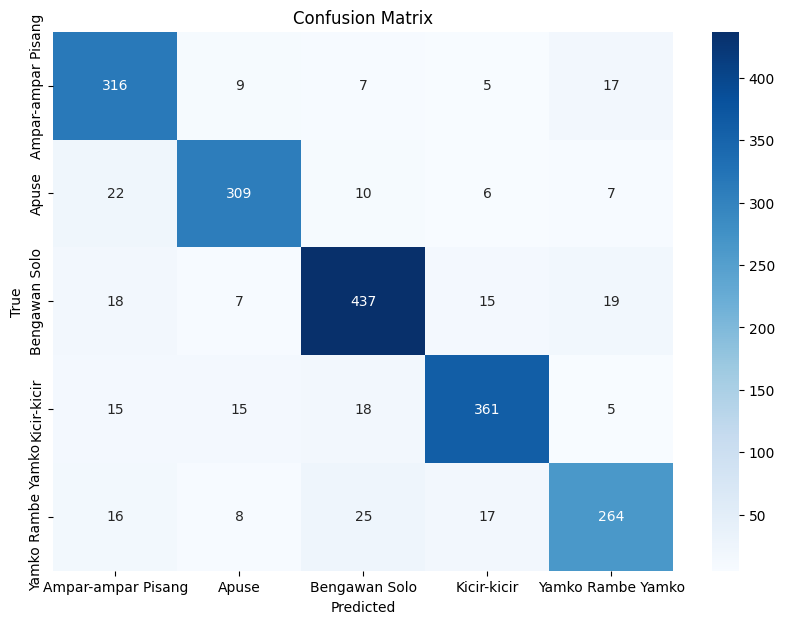

In [62]:
# confusion matrix
y_pred = knn_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [63]:
# save all models
import pickle

# Save the models
with open('models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)
    
with open('models/svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)
    
with open('models/decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dt_model, file)
    
with open('models/knn_model.pkl', 'wb') as file:
    pickle.dump(knn_model, file)

In [72]:
def mfcc_feature(file_path):
    """
    Extract MFCC (Mel-frequency cepstral coefficients) features from an audio file.

    Args:
        file_path (str): Path to the audio file.

    Returns:
        numpy.ndarray: Processed MFCC features.
    """
    try:
        audio, sample_rate = librosa.load(file_path)
        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    except Exception as e:
        logging.error(f"Error encountered while parsing file: {file_path}")
        return None 
     
    return mfcc

In [67]:
# test with external data
def predict_song(model, file_path):
    """
    Predicts the genre of a song using a trained model.

    Args:
        model: The trained model to use for prediction.
        file_path (str): The path to the audio file to predict.

    Returns:
        str: The predicted genre of the song.
        float: The probability of the predicted genre.
    """
    features = mfcc_feature(file_path)
    
    if (features is None):
        return None, None
    
    prediction = model.predict([features])
    probability = model.predict_proba([features])
    
    return prediction[0], np.max(probability)


In [76]:
# svm_pred = predict_song(svm_model, 'test/Yamke Rambo.m4a')
# print(f"Predicted song: {svm_pred}")

rf_pred, rf_prob = predict_song(model, 'test/Yamke Rambo.m4a')
print(f"Predicted song: {rf_pred}")
print(f"Probability: {rf_prob * 100:.2f}%")

dt_pred, dt_prob = predict_song(dt_model, 'test/Yamke Rambo.m4a')
print(f"Predicted song: {dt_pred}")
print(f"Probability: {dt_prob * 100:.2f}%")

knn_pred, knn_prob = predict_song(knn_model, 'test/Yamke Rambo.m4a')
print(f"Predicted song: {knn_pred}")
print(f"Probability: {knn_prob * 100:.2f}%")

/tmp/ipykernel_53791/1820902920.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path)
/home/katow/.pyenv/versions/3.10.15/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_53791/1820902920.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path)
/home/katow/.pyenv/versions/3.10.15/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Predicted song: Bengawan Solo
Probability: 23.00%
Predicted song: Ampar-ampar Pisang
Probability: 100.00%
Predicted song: Apuse
Probability: 80.00%


/tmp/ipykernel_53791/1820902920.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sample_rate = librosa.load(file_path)
/home/katow/.pyenv/versions/3.10.15/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
